In [41]:
i = 2
eeg_file = f"em_0{i}.vhdr"
log_file = f"em_0{i}.pickle"


Channels marked as bad: none
Extracting parameters from C:\Vision\Raw Files\em_02.vhdr...
Setting channel info structure...
Reading 0 ... 194824  =      0.000 ...   779.296 secs...
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 sec)



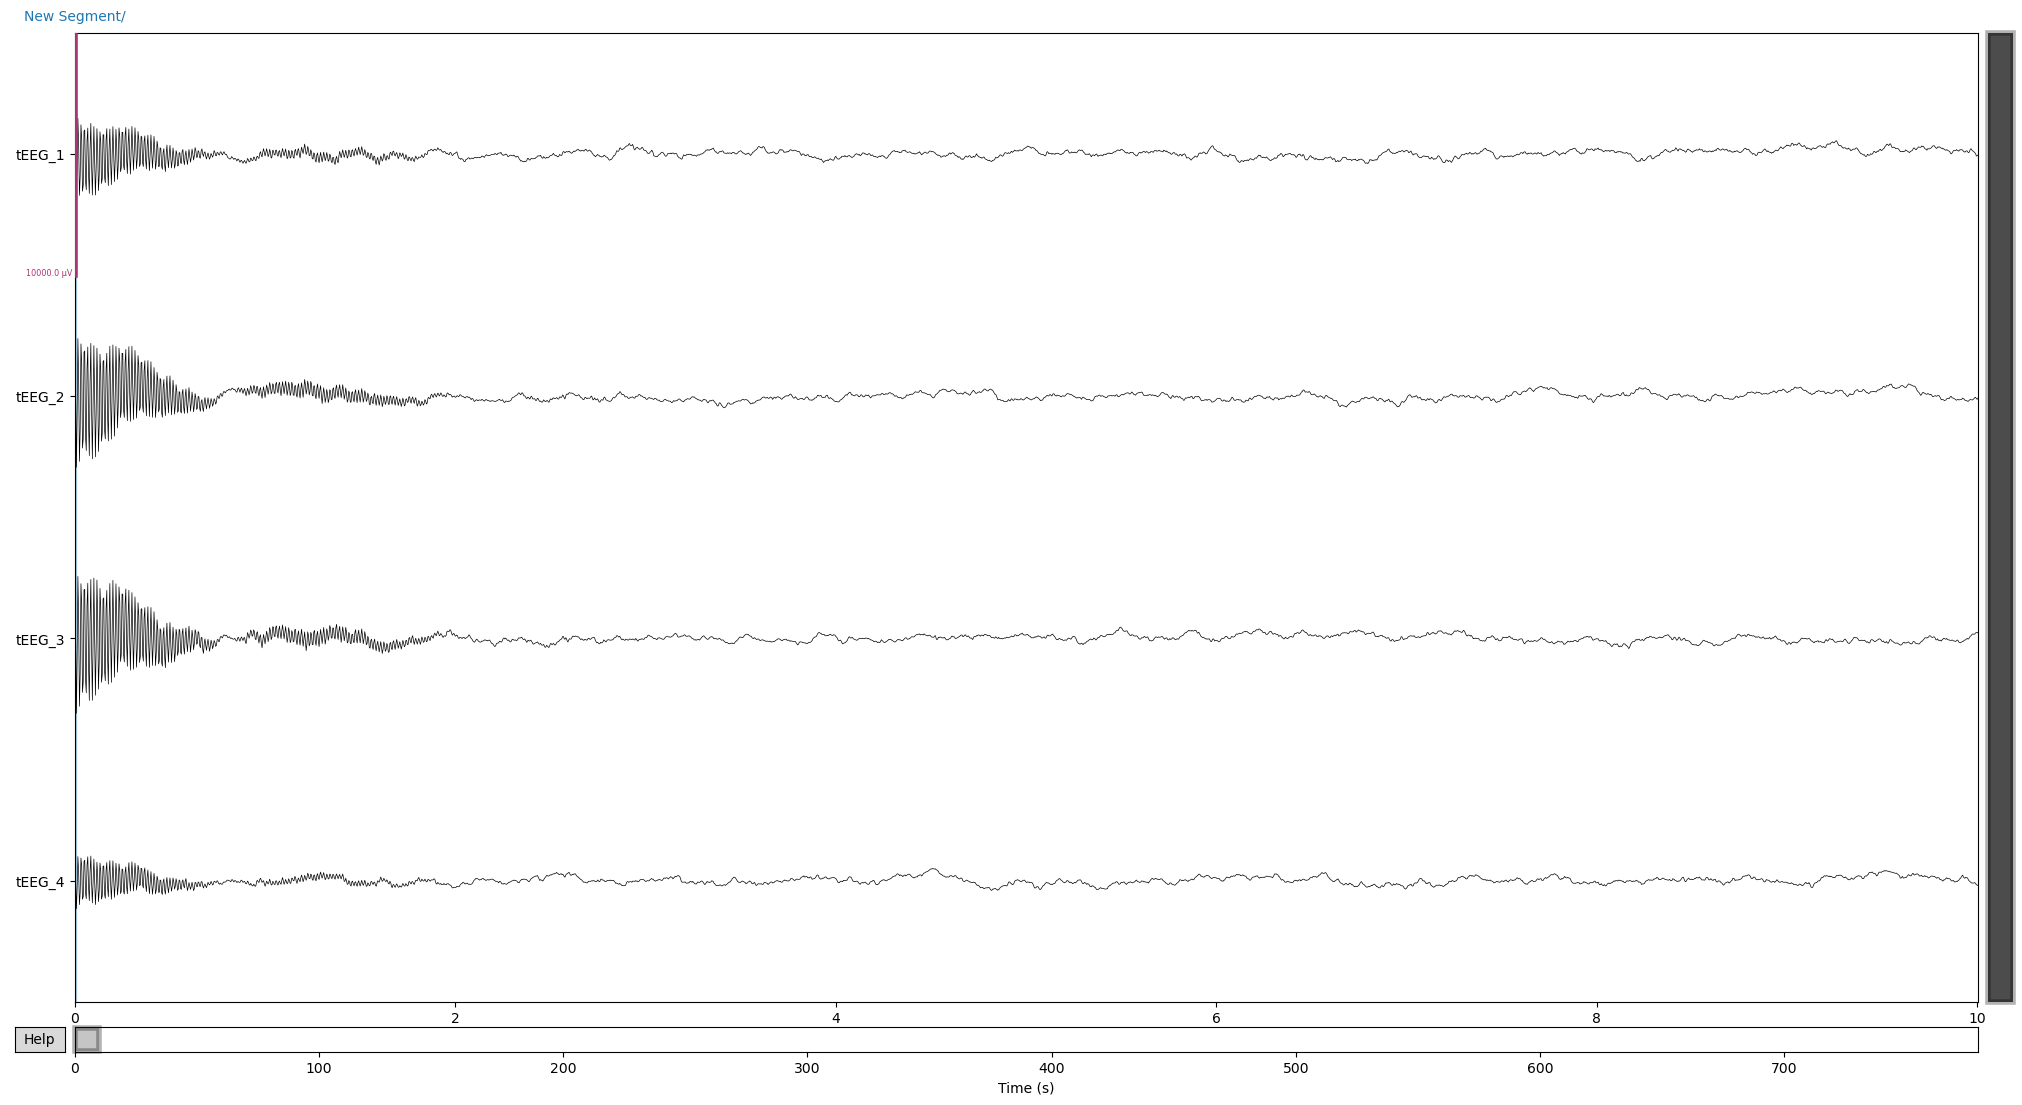

Channels marked as bad: none


In [43]:
%matplotlib qt

raw = mne.io.read_raw(f"C:\Vision\Raw Files\\{eeg_file}",preload=True)
channels = []
for i in range(1 , 21):
    channels.extend([f'eEEG_{i}'])
for i in range(5, 21):
    channels.extend([f'tEEG_{i}'])
channels.extend(['Imp_O', 'Imp_C', 'Imp_M', 'REF_copy', 'photosensor'])
raw.drop_channels(channels)
raw.notch_filter(60).plot(scalings={'eeg':50e-4}, show=True)

In [40]:
import mne
raw = mne.io.read_raw(f"C:\Vision\Raw Files\\{eeg_file}")
sfreq = raw.info['sfreq']
raw.info

Extracting parameters from C:\Vision\Raw Files\em_02.vhdr...
Setting channel info structure...


<Info | 7 non-empty values
 bads: []
 ch_names: Imp_O, Imp_M, Imp_C, tEEG_1, tEEG_2, tEEG_3, tEEG_4, tEEG_5, ...
 chs: 45 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 69.0 Hz
 meas_date: 2022-04-04 22:09:15 UTC
 nchan: 45
 projs: []
 sfreq: 250.0 Hz
>

In [21]:
photosensor_data = raw['photosensor'][0].reshape(-1)
photosensor_times = raw['photosensor'][1].reshape(-1)

# Identify cue sequence indices

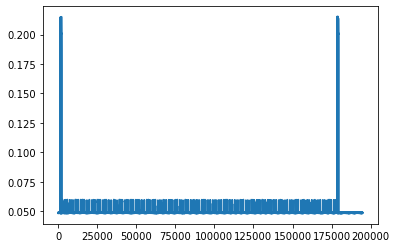

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.plot(photosensor_data)

In [23]:
a1 = np.where(photosensor_data > 0.075)[0]  
a2 = np.where(photosensor_data < .21)[0]
verticals = np.intersect1d(a1, a2)
verticals


array([  1139,   1140,   1143, ..., 179571, 179572, 179573], dtype=int64)

In [24]:
second_sequence_idx = verticals[np.where(np.diff(verticals) > 10000)[0][0]+1]
first_sequence_idx = verticals[0]
first_sequence_idx, second_sequence_idx

(1139, 178404)

In [7]:
%matplotlib qt 
plt.plot(photosensor_data)
plt.scatter([first_sequence_idx,second_sequence_idx ], [.075]*2, color='red', marker='x')

# Check Cue pickle file alignment

In [25]:
import pickle
with open(log_file, 'rb') as f:
    log_file = pickle.load(f)

In [26]:
log_file['cues']

0              Sync Sequence
0           Experiment Start
0                       Rest
0              Cue Presented
0          Action:Stay Still
              ...           
0    Action:Perform Movement
0                       Rest
0              Cue Presented
0    Action:Perform Movement
0              Sync Sequence
Name: cues, Length: 153, dtype: object

## Compare time difference between photosensor data and cue data

In [27]:
log_file.columns

Index(['time', 'cues'], dtype='object')

In [28]:
(log_file['time'].values[-1] - log_file['time'].values[0]) *250

177249.9892115593

In [29]:
(second_sequence_idx - first_sequence_idx) 

177265

# Allign Data

In [30]:
# to align times 
# we need to have the same time for the first sequence in both files.
# 1. subtract the time of first sequence from all times 

log_times = np.array(log_file['time'])
log_times = log_times - log_times[0]
log_times

array([  0.        ,   5.15849853,   5.16946673,  11.22218251,
        15.24172378,  19.25632405,  25.27283835,  29.29903817,
        33.33905721,  39.36193895,  43.38057065,  47.41000247,
        53.45306039,  57.47560263,  61.50763083,  67.53404117,
        71.56458712,  75.60307264,  81.61763954,  85.6350019 ,
        89.6470809 ,  95.68290281,  99.72284842, 103.75062966,
       109.78346372, 113.81021857, 117.83257747, 123.85261106,
       127.88175178, 131.90562463, 137.93214488, 141.97800565,
       146.00182462, 152.02813292, 156.03757191, 160.04833436,
       166.06947279, 170.09228992, 174.11517954, 180.13195562,
       184.15807843, 188.19612694, 194.22939634, 198.25259662,
       202.28180122, 208.31403852, 212.33371258, 216.35682464,
       222.37834597, 226.39718342, 230.42730784, 236.4699111 ,
       240.50078535, 244.52520704, 250.53614235, 254.56581092,
       258.59016895, 264.60954547, 268.64249253, 272.66352534,
       278.70063877, 282.74305844, 286.77285433, 292.78

In [31]:
photosensor_times = raw['photosensor'][1].reshape(-1)
photosensor_times

array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 7.79288e+02,
       7.79292e+02, 7.79296e+02])

In [32]:
# 2. add the time at first_sequence_idx found from photosensor data
log_times = log_times + photosensor_times[first_sequence_idx]

In [33]:
cue_names = np.array(log_file['cues'])
key_press_idxs = np.flatnonzero(np.core.defchararray.find(cue_names,'key')!=-1)
non_key_press_idxs = np.flatnonzero(np.core.defchararray.find(cue_names,'key')==-1)
cue_names[key_press_idxs], cue_names[non_key_press_idxs]

TypeError: string operation on non-string array

In [ ]:
%matplotlib qt
plt.plot(photosensor_times, photosensor_data)
plt.scatter(log_times[key_press_idxs], [.09]*log_times[key_press_idxs].shape[0], color='red', marker='x')
plt.scatter(log_times[non_key_press_idxs], [.09]*log_times[non_key_press_idxs].shape[0], color='green', marker='x')
plt.show()

# Add Event/Cue information to MNE Object 

In [34]:
def convert_cues_to_mne_events(photosensor_times, log_times, cue_names):

    unique_cues = np.unique(cue_names)
    cue_name_dictionary = {}
    cue_id_dictionary = {}
    for i, cue in enumerate(unique_cues):
        cue_name_dictionary[cue] = i
        cue_id_dictionary[i] = cue

    #get sample index of log times
    log_sample_idxs = [find_nearest(photosensor_times, x) for x in log_times]
    # return log_sample_idxs
    events = np.array([[0,0,0]])
    for log_idx, cue_name in zip(log_sample_idxs, cue_names):
        events = np.vstack((events, np.array([log_idx, 0, cue_name_dictionary[cue_name]])))
    
    return events[1:],  cue_name_dictionary, cue_id_dictionary

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [35]:
events, d1, d2 = convert_cues_to_mne_events(photosensor_times, log_file['time'], log_file['cues'])
assert np.where(np.diff(events[:, 0].astype(int)) < 0)[0].shape[0] == 0, 'problem in time order'

## Visualize

In [36]:
channels = []
for i in range(1, 21):
    channels.extend([f'eEEG_{i}'])
for i in range(5, 21):
    channels.extend([f'tEEG_{i}'])
channels.extend(['Imp_O', 'Imp_C', 'Imp_M', 'REF_copy'])
raw.drop_channels(channels)

<RawBrainVision | em_02.eeg, 5 x 194825 (779.3 s), ~10 kB, data not loaded>

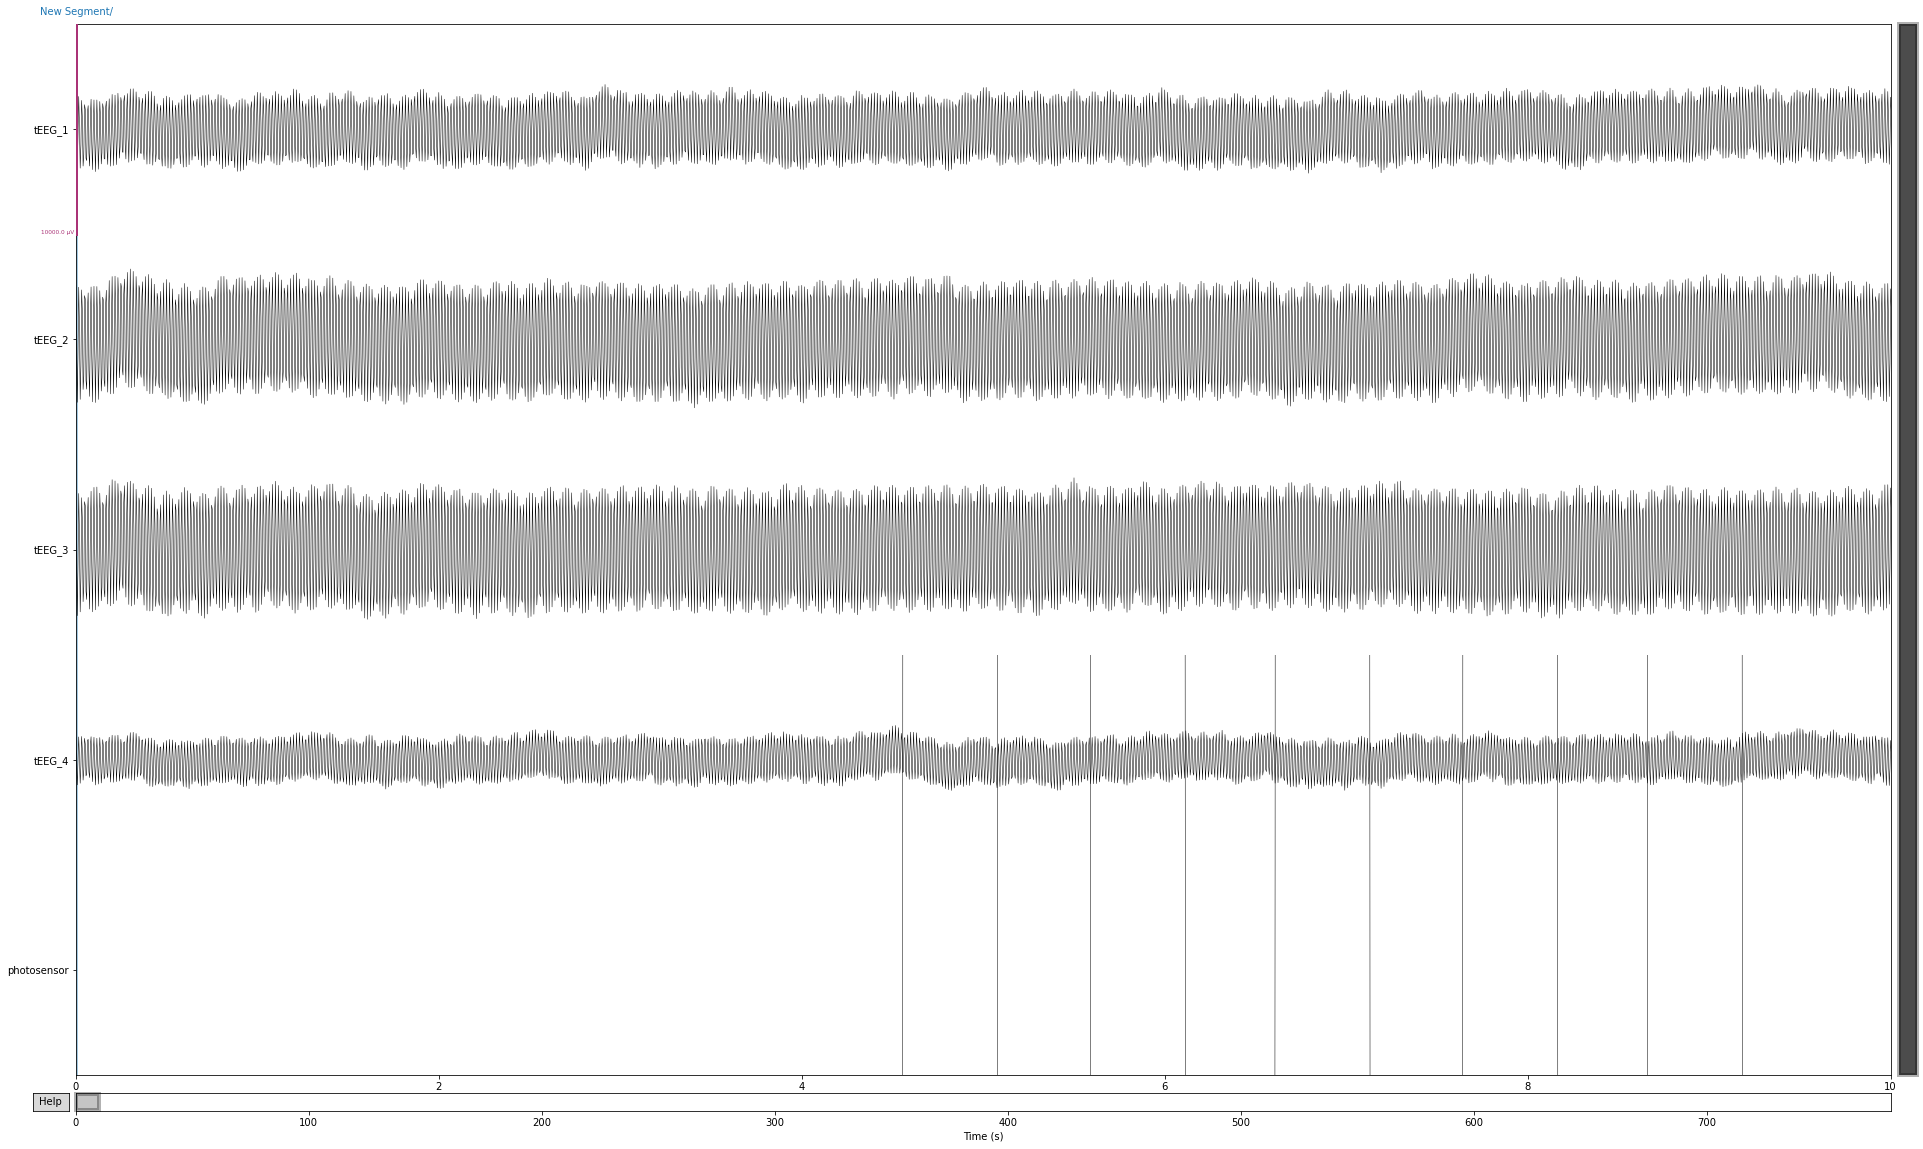

In [42]:
%matplotlib qt
raw.plot(events=events, scalings={'eeg':50e-4}, event_id=d1, show=True)


In [53]:
data = raw['tEEG_1'][0].reshape(-1)[:100]* 0.0488281
data.shape

(100,)

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.plot(data)